<a href="https://colab.research.google.com/github/valenciajaime/GCoupling_v0/blob/master/Metodo_Schlumberger_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portada

Autores: WMV&JMR&JAVV
Email: 
Mauricio Villa <walter.villa@udea.edu.co>

       JOHNATAN MAURICIO RODRIGUEZ SERNA  <jmauricio.rodriguez@udea.edu.co>

       
       Jaime A.Valencia <jalejandro.valencia@udea.edu.co> 

       
       Alvaro Jaramillo <alvaro.jaramillod@udea.edu.co>

Seminario integrador:        
Jorge Bohorquez <jorge.bohorquez@udea.edu.co>

Fecha: 2022-abril-20 miercoles

Tomado de:

Mod_multilayer05.py


# Descripcion

**Objetivo**

UsandoCreacion de clase con el metodo de Schulumberger para procesar mediciones de resistividad y ajustar el modelo de 2 capas.

Imagen de Evaluation of Grounding Resistance and Inversion
Method to Estimate Soil Electrical Grounding
Parameters by F. H. Slaoui, F. Erchiqui

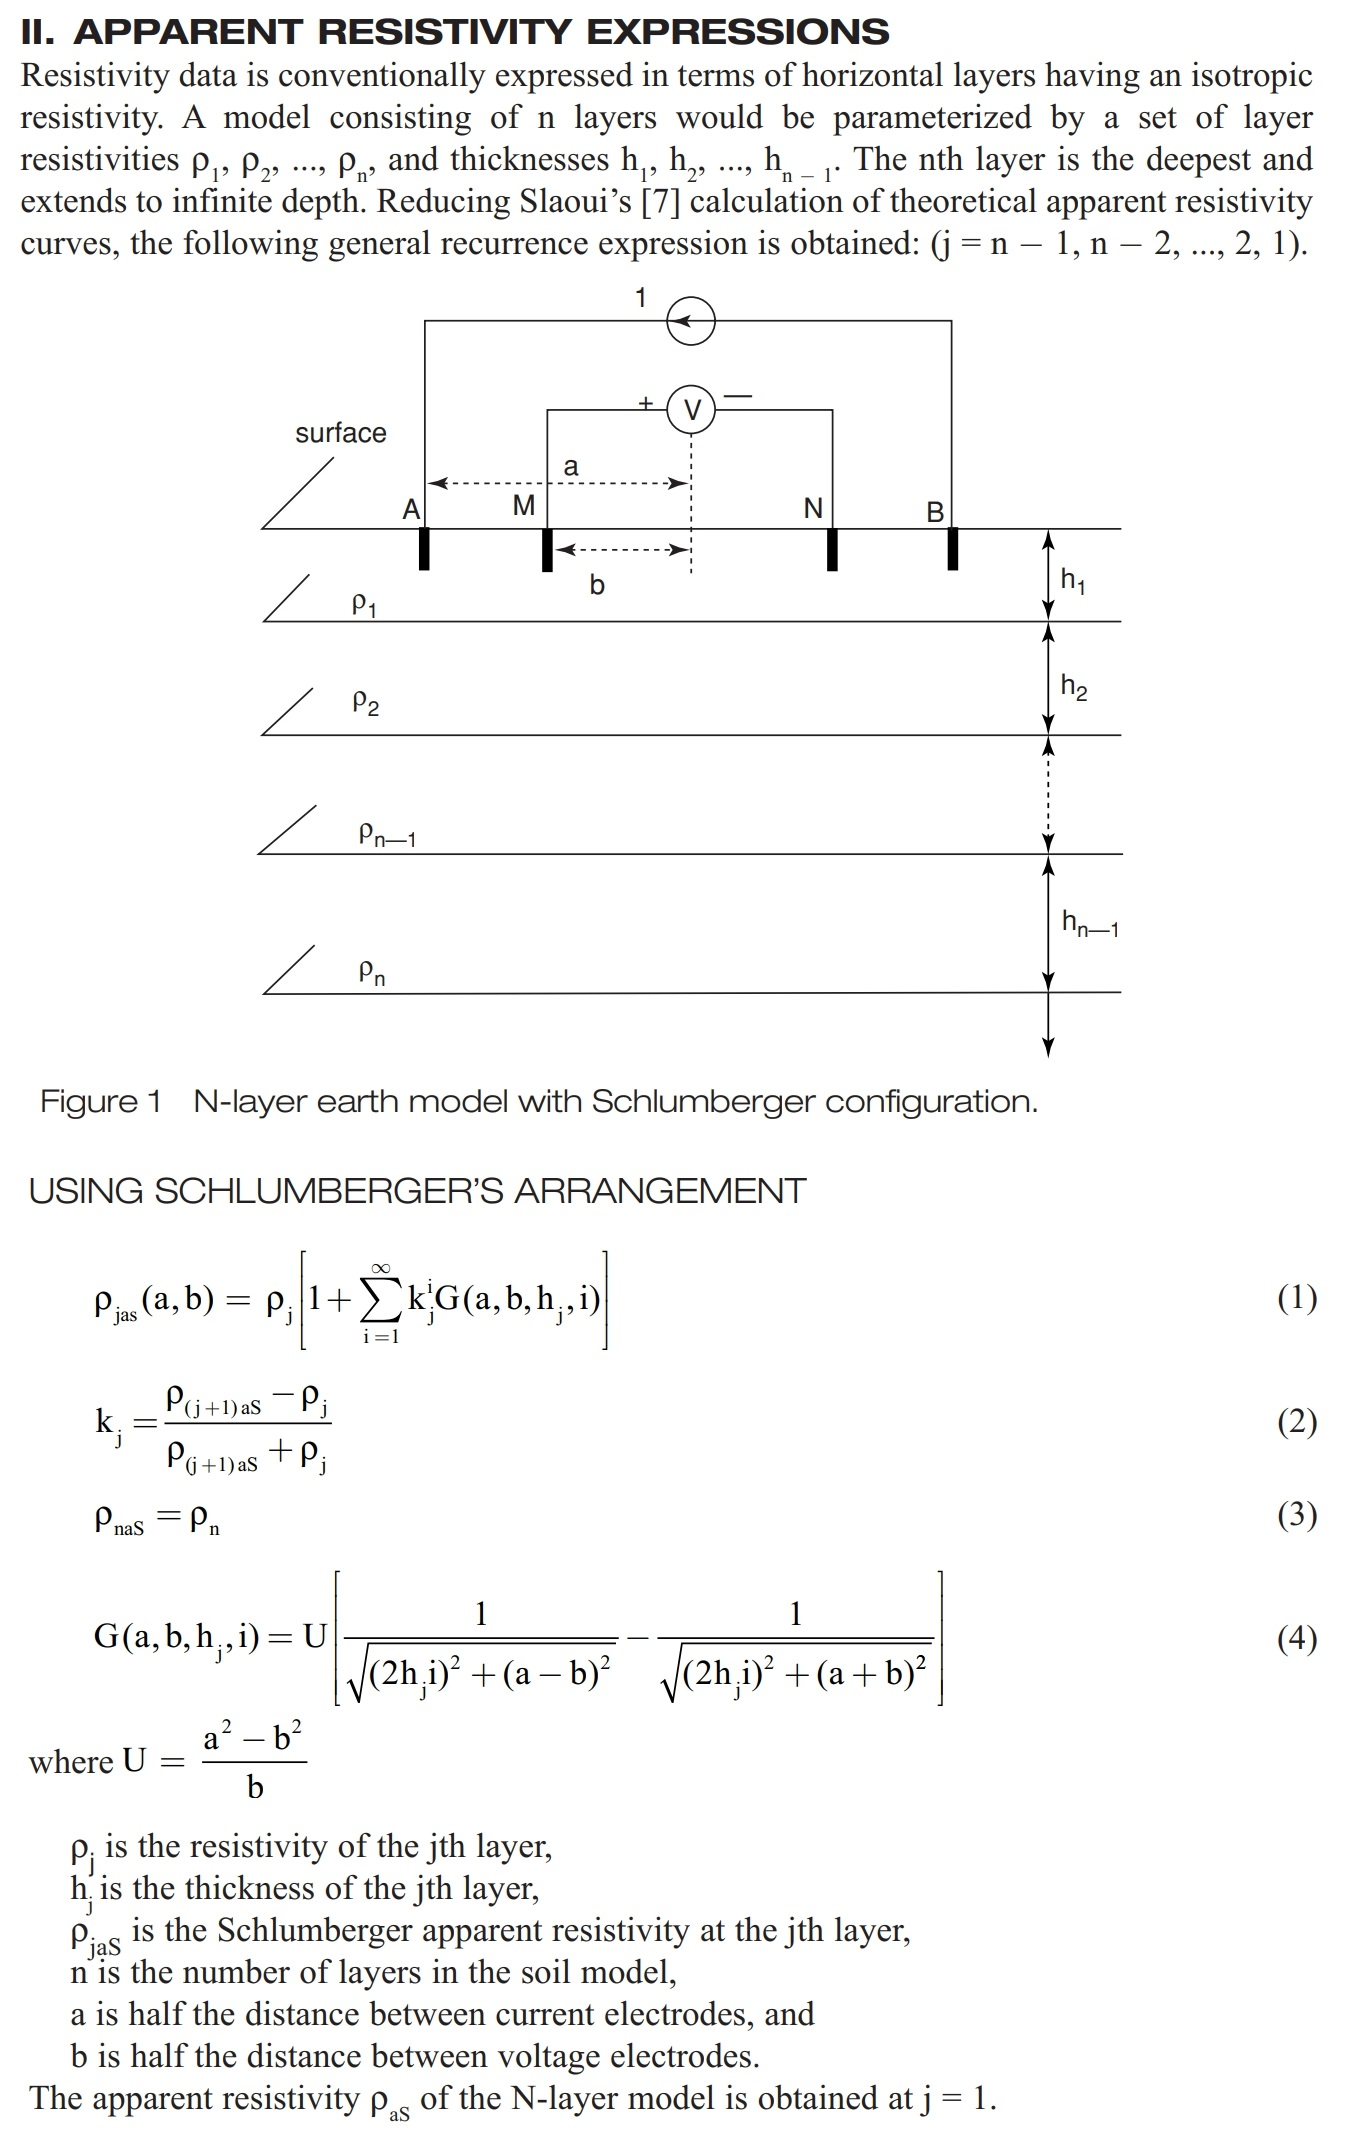

# Importacion de modulos

In [ ]:
#Importaciones
import os
import numpy as np
import pylab as plt
from scipy import optimize as OP
#Mod_multilayer05:  se copian las funciones de este modulo
#que se requieren

## Clase

class Medida_GT02(object):
  """Clase para manejo de medidas de resistividad
     -Obtener modelo de suelo de 1 y 2 capas
     
     .Metodo de Schulemberg(En otra clase)

     ver. lunes 2022-abril-18
  """
  def __init__(self):
    """ Inicio con datos de prueba??
        
       ver. lunes 2022-abril-18
    """
    print("inicio clase Medida_GT02")
    #Datos metodo Slumberger
    #ab_dist: distancias a y b para el metodo de Schulemberg
    # a: distancia del centro al eletrodo de corriente
    # b: distancia del centro al electrodo de potencial
    ##'ro0_ro1': array([364.68447103, 143.63899288]), 'ho': 2.82788
    ##Datos de prueba tomados de Wenner
    self.Dat_slumbg={"ab_dist": np.array([[3.75,7.5,11.25,15.0,18.75,22.5],[1.25,2.5,3.75,5.0,6.25,7.5]]),
                     "ro_med": [320.0, 245.0, 182.0, 162.0, 168.0, 152.0],
                     "ro0_ro1": [], "ho":[],
                     "ro_ajust":[]}
    return

  def Resistivity_Slumbg0(self,a=2, b=0.5, ro=[100,200], h=1.5, Np=10):
    """
    a: distancia entre los electrodos de corriente del método de schlumberger
    b: distancia entre los electrodos de voltaje del método de schlumberger
    ro: vector que corresponde a las valores de resistividad del suelo
       [ro_capa1, ro_capa2]
    h : escalar que corresponde a la profundidad del modelo de dos capas
    Np: numero de elementos de la serie (iteraciones)
    roc: la resistividad aparente calculada

    ver. Jorge A. Bohorquez
         Lunes 2022-abril-18
    """
    a_ro = np.array(ro)
    
    k = (a_ro[1:]-a_ro[:-1])/(a_ro[1:]+a_ro[:-1])#% calculo de los coeficientes de reflexión

    u=(a**2-b**2)/b

    Suma1= 0
    for q in range(1,Np):
        kn = k[0]**q
        cn = (2*q*h)**2
        u1 = (a-b)**2
        u2 = (a+b)**2
        c1 = kn/np.sqrt(cn+u1)
        c2 = kn/np.sqrt(cn+u2)
        Suma1 += u*(c1-c2)
    roc = ro[0]*(1 + Suma1)
        
    return roc

  def Error_Slumbg0(self,Xd,M_a,M_ro):
    """Xd:[ro1,ro2,h]  M_ab:array distancias(a: fila 0, b:fila 1)
        M_ro:lista resistividad
       Calcula el error cuadratico medio con el modelo de 2 capas
       usando la funcion Resistivity_Slumbg0().
       
       columnas(M_a) == len(M_ro) debe cumplirse

       rev: 2018-06-13
    """
    roi = Xd[:2]; hi=Xd[2]
    NN = len(M_ro)
    S_errorc=0
    for q in range(NN):
      ai = M_a[0,q]
      bi = M_a[1,q]
      ro_m = self.Resistivity_Slumbg0(ai, bi, roi, hi, Np=10)
      ec = (ro_m-M_ro[q])**2
      S_errorc += ec
    Er = S_errorc/NN
    return Er

  def Get_ajuste_Slumberg0(self,ferror,X0,Dato_h,Dato_ro, Niter=0):
    """ferror: funcion de error,  X0: inicio[ro h]
       Dato_ro: medidas de resistividad aparante
       Dato_H: distancias de medidas Slumberger
               array 2 filas. a:fila 0, b:fila 1
               igual numero de columnas que Dato_ro
       
       ver. 2022-abril-19  (probada datos Wenner)
    """
    RES_0 = OP.minimize(ferror, X0,(Dato_h,Dato_ro))
    if Niter>0:
        xo1 = np.abs(RES_0.x)
        RES_0 = OP.minimize(ferror, xo1,(Dato_h,Dato_ro))
    return RES_0

  def Get_roini(self,M_a,M_ro):
    """M_a:lista distancias  M_ro:lista resistiv
       calcula ro[primero, ultimo]
       Para inicializar ajuste
       rev: 2018-06-13
    """

    Xi = [M_ro[0],M_ro[-1],1]
    return Xi

  def Get_Show_Slumbg0(self, itt = 0):
    """Calculo de parametros modelo de suelo de  2 capas
       a partir de datos de Wenner usando:
       Get_roini()
       Error_Slumbg0()
       Get_ajuste_Slumbg0()
       Dat_slumbg{}

       ver. lunes 2022-abril-19
    """
    Xo = self.Get_roini(self.Dat_slumbg["ab_dist"], self.Dat_slumbg["ro_med"])
    print("Xo: ",Xo)
    #Esta funcion calcula el error
    er1 = self.Error_Slumbg0(Xo,self.Dat_slumbg["ab_dist"], self.Dat_slumbg["ro_med"])
    print("Error inicial: ",er1)

    ##ajuste de parametros
    ##funcion de optimizacion en el modulo
    ## utiliza scipy.optimize.minimize()
    Ajuste1 = self.Get_ajuste_Slumberg0(self.Error_Slumbg0, Xo,
                                      self.Dat_slumbg["ab_dist"],
                                      self.Dat_slumbg["ro_med"], Niter=itt)
    print("Modelo de 2 capas (Slumberger)")
    print("ro1, ro2 : ",Ajuste1.x[:2])
    print("ho : ",Ajuste1.x[2])
    print("Error logrado: ",Ajuste1.fun)

    ro1_ajuste1 = self.Resistivity_Slumbg0(a=self.Dat_slumbg["ab_dist"][0,:],b=self.Dat_slumbg["ab_dist"][1,:], ro=Ajuste1.x[:2], h=Ajuste1.x[2], Np=10)

    
    self.Dat_slumbg["ro0_ro1"]=Ajuste1.x[:2]
    self.Dat_slumbg["ho"]=Ajuste1.x[2]
    self.Dat_slumbg["ro_ajust"]= ro1_ajuste1
    return

  def Plot_Slumb0(self):
    """Grafico de datos y modelo de Wenner:
       .Dat_wenner

       ver. lunes 2022-abril-19
       Para version matplotlib 3.1.1
    """
    try:
      from mpl_toolkits.mplot3d import Axes3D
      fig = plt.figure()
      ax = fig.gca(projection='3d')

      ##datos grafico
      xf = self.Dat_slumbg["ab_dist"][0,:]
      yf = self.Dat_slumbg["ab_dist"][1,:]

      z_data = self.Dat_slumbg["ro_med"]
      z_ajust = self.Dat_slumbg["ro_ajust"]

      ax.plot(xf,yf,z_data,"ro")
      ax.plot(xf,yf,z_ajust,"b*-")
      ax.legend(["Medidas","Modelo"])

      plt.title("Resistividad apar. (ohms-m)")
      plt.xlabel("Dist a(E corriente)")
      plt.ylabel("Dist b(E potencial)")
      plt.grid("on")
      plt.show()

    except:
      print("Falta calcular modelo")
    return

  def Set_DatS0(self,d_new, ro_new):
    """d_new : array 2 filas distancias a(e corriente) b(e potencial)
       ro_new : lista resistividades aparentes medidas.
       Asignar nuevos valores de medida
    """
    d_new = np.array(d_new)
    self.Dat_slumbg["ab_dist"]= d_new
    self.Dat_slumbg["ro_med"]= ro_new
    self.Get_Show_Slumbg0()
    return



# Datos en la Clase Medida_GT02

In [ ]:
# Creacion de objeto para procesar medidas Schulemberger
Ot2 = Medida_GT02()

#Ver datos en el objeto
print("Datos por defecto: ",Ot2.Dat_slumbg)


inicio clase Medida_GT02
Datos por defecto:  {'ab_dist': array([[ 3.75,  7.5 , 11.25, 15.  , 18.75, 22.5 ],
       [ 1.25,  2.5 ,  3.75,  5.  ,  6.25,  7.5 ]]), 'ro_med': [320.0, 245.0, 182.0, 162.0, 168.0, 152.0], 'ro0_ro1': [], 'ho': [], 'ro_ajust': []}


# Obtener ajuste de datos Schulemberger

In [ ]:
#Calculo de ajuste de datos
Ot2.Get_Show_Slumbg0()

Xo:  [320.0, 152.0, 1]
Error inicial:  3906.990939840296
Modelo de 2 capas (Slumberger)
ro1, ro2 :  [364.68414729 143.63889367]
ho :  2.827893725369335
Error logrado:  42.967779851902215


# Observar resultados

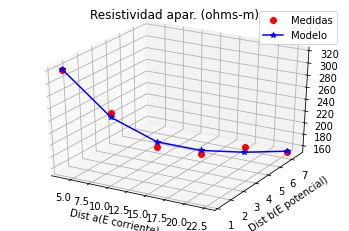

In [ ]:
## ver resultados
Ot2.Plot_Slumb0()


# Calculo con nuevas medidas


In [ ]:
## nuevos datos

d_sl = [[1.5, 1.95, 2.4, 3.0, 4.5, 6.0, 7.5, 9.0, 12.0, 15.0],
        [0.5, 0.65, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0]]
ro_sl = [282.0, 261.0, 236.0, 192.0, 141.0, 128.0, 120.0, 118.0, 112.0, 111.0]

Ot2.Set_DatS0(d_sl,ro_sl)

Xo:  [282.0, 111.0, 1]
Error inicial:  601.7543999935958
Modelo de 2 capas (Slumberger)
ro1, ro2 :  [338.26139112 108.08663895]
ho :  1.0859313906116248
Error logrado:  18.980347998903294


# Resultado nuevos datos

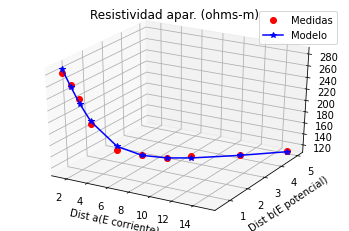

In [ ]:
Ot2.Plot_Slumb0()